In [1]:
import py4hw 
import numpy as np

In [2]:
class ManchesterDecoder(py4hw.Logic):
    def __init__(self, parent, name, R0, R1,out,error):
        super().__init__(parent, name)

        self.addIn('R0', R0)
        self.addIn('R1', R1)
        self.addOut('out', out)
        self.addOut('error', error)

        n_error=self.wire('n_error')
        py4hw.Xor2(self,'Xor2',R0,R1,n_error)
        py4hw.Not(self,'Not',n_error,error)
        py4hw.Buf(self,'out',R1,out)

In [3]:
hw = py4hw.HWSystem()

R0 = hw.wire('R0')
R1 = hw.wire('R1')

out = hw.wire('out')
error = hw.wire('error')

py4hw.Sequence(hw,'R0', [0, 1], R0)
py4hw.Sequence(hw,'R1', [0, 0, 1, 1], R1)

dut = ManchesterDecoder(hw,'man',R0,R1,out,error)

wvf = py4hw.Waveform(hw, 'wvf', [R0,R1,out,error])

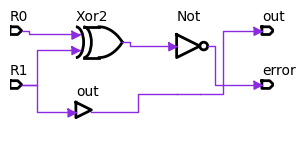

In [4]:
sch = py4hw.Schematic(dut)
sch.draw()

In [5]:
hw.getSimulator().clk(10)
wvf.draw_wavedrom()

In [6]:
class FSM(py4hw.Logic):
    def __init__(self, parent, name, start, error, carry32,carry64,ena_32,rst_32,ena_64,rst_64,ena_R0,ena_R1):
        super().__init__(parent, name)
        self.start   = self.addIn('start', start)
        self.error   = self.addIn('error', error)
        self.carry32 = self.addIn('carry32', carry32)
        self.carry64 = self.addIn('carry64', carry64)
        self.ena_32 = self.addOut('ena_32', ena_32)
        self.rst_32 = self.addOut('rst_32', rst_32)
        self.ena_64 = self.addOut('ena_64', ena_64)
        self.rst_64 = self.addOut('rst_64', rst_64)
        self.ena_R0 = self.addOut('ena_R0', ena_R0)
        self.ena_R1 = self.addOut('ena_R1', ena_R1)
        
        self.IDLE, self.INC32, self.PREINC64, self.INC64 = 0, 1, 2, 3
        self.state = 0
        self.debug = ''
        
    def clock(self):
        if self.state == self.IDLE:
            self.ena_32.prepare(0)
            self.ena_64.prepare(0)
            self.ena_R0.prepare(0)
            self.ena_R1.prepare(0)
            #self.rst_32.prepare(0)
            #self.rst_64.prepare(1)
            if self.start.get() == 1:
                self.state = self.INC32
                self.rst_32.prepare(1)
                self.rst_64.prepare(1)
                self.debug = 'IDLE-->INC32'
            else:
                self.state =self.IDLE
                self.rst_32.prepare(0)
                self.rst_64.prepare(0)
                self.debug = 'IDLE-->IDLE'
            
        elif self.state == self.INC32:
             self.rst_32.prepare(0)
             self.rst_64.prepare(0)
             if self.carry32.get() == 1:
                 self.state=self.PREINC64
                 self.ena_32.prepare(1)
                 self.ena_64.prepare(0)
                 self.ena_R0.prepare(1)
                 self.ena_R1.prepare(1)
                 self.debug = 'INC32-->INC64'
             else:
                 self.state=self.INC32
                 self.ena_32.prepare(1)
                 self.ena_64.prepare(0)
                 self.ena_R0.prepare(0)
                 self.ena_R1.prepare(0)
                 self.debug = 'INC32'

        elif self.state == self.PREINC64:
            self.state=self.INC64
            self.ena_R0.prepare(0)
            self.ena_R1.prepare(0)
            
        elif self.state == self.INC64:
             self.rst_32.prepare(0)
             self.rst_64.prepare(0)
            
             if self.error.get() == 1:
                 self.state=self.IDLE
                 self.ena_32.prepare(0)
                 self.ena_64.prepare(0)
                 self.ena_R0.prepare(0)
                 self.ena_R1.prepare(0)
                 #self.debug = 'INC64-->IDLE'
                 self.debug = f'err={self.error.get()}'

             elif self.carry64.get() == 1:
                 #self.state=self.INC64
                 self.ena_32.prepare(0)
                 self.ena_64.prepare(1)
                 self.ena_R0.prepare(1)
                 self.ena_R1.prepare(1)
                 self.debug = 'INC64'
             else:
                 #self.state=self.INC64
                 self.ena_32.prepare(0)
                 self.ena_64.prepare(1)
                 self.ena_R0.prepare(0)
                 self.ena_R1.prepare(0)     
                 self.debug = 'INC64'
                
        else:
            self.state=self.IDLE

In [144]:
hw = py4hw.HWSystem()

start = hw.wire('start')
error = hw.wire('error')
carry32 = hw.wire('carry32')
carry64 = hw.wire('carry64')

ena_32 = hw.wire('ena_32')
rst_32 = hw.wire('rst_32')
ena_64 = hw.wire('ena_64')
rst_64 = hw.wire('rst_64')
ena_R0 = hw.wire('ena_R0')
ena_R1 = hw.wire('ena_R1')

start_seq = [int(x) for x in '000010000000000']
carry32_seq = [int(x) for x in '00000001']
carry64_seq = [int(x) for x in '0000000000001']

py4hw.Sequence(hw, 'start_seq', start_seq, start)
py4hw.Sequence(hw, 'carry32_seq', carry32_seq, carry32)
py4hw.Sequence(hw, 'carry64_seq', carry64_seq, carry64)

fsm = FSM(hw, 'fsm', start,error, carry32, carry64, ena_32, rst_32, ena_64, rst_64, ena_R0, ena_R1)

wvf = py4hw.Waveform(hw, 'wvf', [start, carry32, carry64,
                      ena_32, ena_64, rst_32, rst_64,
                      ena_R0, ena_R1,  py4hw.FieldInspector(fsm, 'state')])

hw.getSimulator().clk(20)
wvf.draw_wavedrom()

In [145]:
hw = py4hw.HWSystem()
a = hw.wire('a')
r = hw.wire('r')

a_seq = np.load("cap3_seq.npy").astype(int).tolist()
#print(a_seq)
py4hw.Sequence(hw, 'a_seq', a_seq,a)

ED = py4hw.EdgeDetector(hw, 'ED', a, r, 'pos')

wvf = py4hw.Waveform(hw, 'wvf', [a,r])

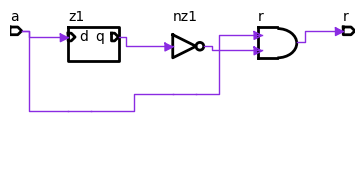

In [146]:
sch = py4hw.Schematic(ED)
sch.draw()

In [147]:
hw.getSimulator().clk(20)
wvf.draw_wavedrom()

In [148]:
class StreamCapture(py4hw.Logic):
    def __init__(self, parent, name, x, ena=None):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        if not(ena is None):
            self.ena = self.addIn('ena', ena)
        else:
            self.ena = None
            
        self.data = []
        
    def clock(self):
        if (self.ena is None):
            self.data.append(self.x.get())
        else:
            if (self.ena.get()):
                self.data.append(self.x.get())

    def clear(self):
        self.data = []

class StreamCaptureSigned(py4hw.Logic):
    def __init__(self, parent, name, x):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        
        self.data = []
        
    def clock(self):
        self.data.append(py4hw.IntegerHelper.c2_to_signed(self.x.get(), self.x.getWidth()))

    def clear(self):
        self.data = []   

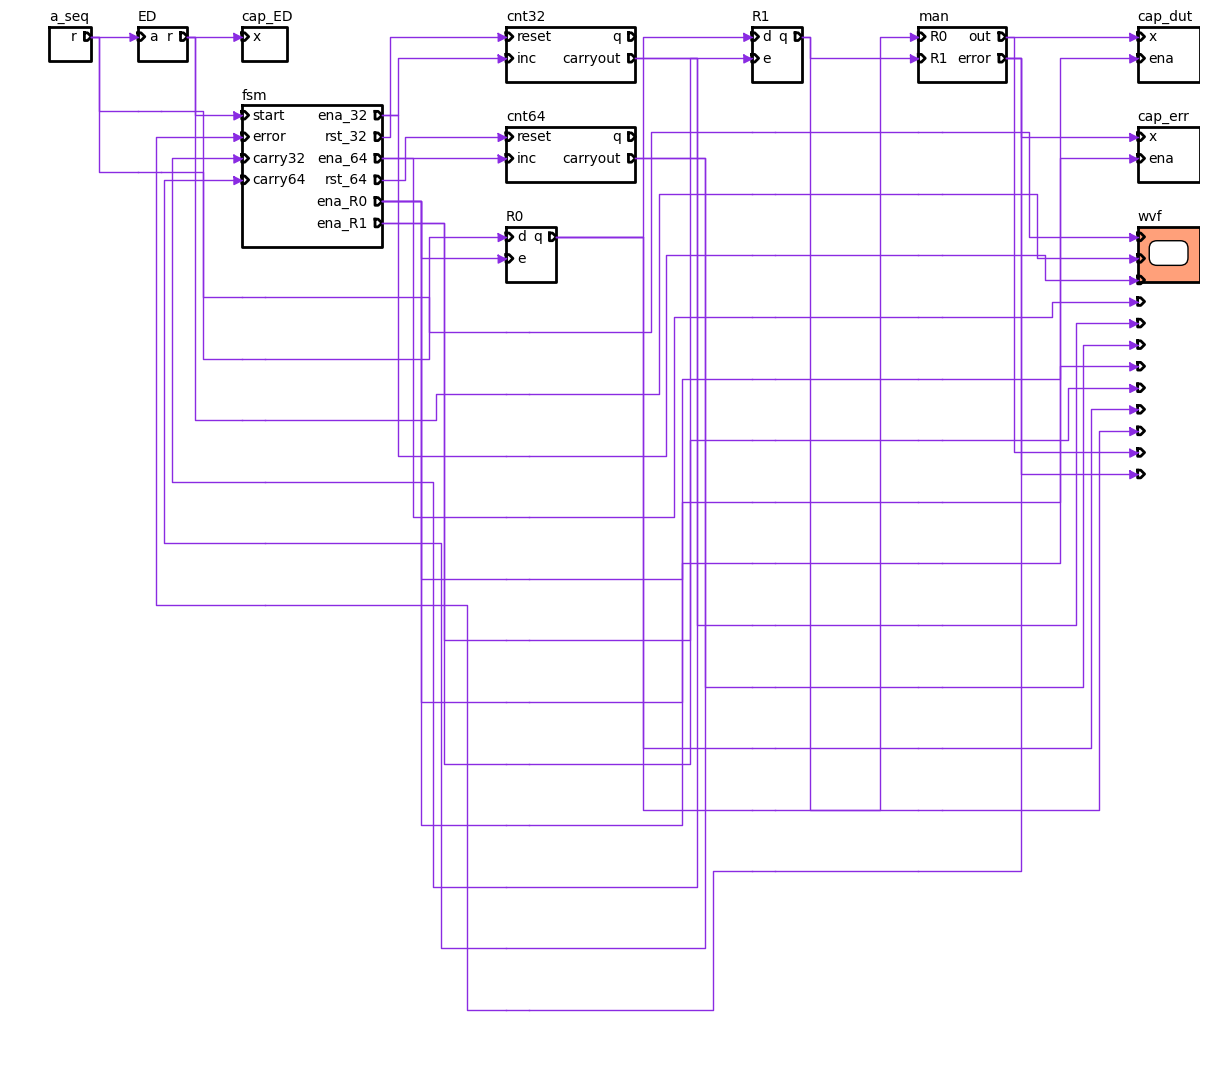

In [160]:
from py4hw import EdgeDetector
from py4hw import ModuloCounter, Reg

hw = py4hw.HWSystem()

a = hw.wire('a')   
a_seq = np.load("cap3_seq.npy").astype(int).tolist()
py4hw.Sequence(hw, 'a_seq', a_seq,a)
#print(a_seq)
edge = hw.wire('edge')       
r = hw.wire('r')

carry32 = hw.wire('carry32') 
carry64 = hw.wire('carry64') 


ena_32 = hw.wire('ena_32')  
rst_32 = hw.wire('rst_32')
ena_64 = hw.wire('ena_64')
rst_64 = hw.wire('rst_64')
ena_R0 = hw.wire('ena_R0')    
ena_R1 = hw.wire('ena_R1') 

q32 = hw.wire('q32',8)
q64 = hw.wire('q64',8)

cnt32_out = hw.wire('cnt32_out')
cnt64_out = hw.wire('cnt64_out')

R0_out = hw.wire('R0_out')
R1_out = hw.wire('R1_out')

out = hw.wire('out')         
error = hw.wire('error') 

ED = EdgeDetector(hw, 'ED', a, edge, 'pos')  
cap_ED = StreamCapture(hw, 'cap_ED', edge)

fsm = FSM(hw, 'fsm', edge, error, carry32, carry64, 
          ena_32, rst_32, ena_64, rst_64, ena_R0, ena_R1)  
#cap_fsm = StreamCapture(hw, 'cap_fsm', ena_R0)


cnt32 = ModuloCounter(hw,'cnt32',mod=32,reset=rst_32,inc=ena_32,q=q32,carryout=carry32)
cnt64 = ModuloCounter(hw,'cnt64',mod=64,reset=rst_64,inc=ena_64,q=q64,carryout=carry64)

R0 = Reg(hw, 'R0', d=a,q=R0_out, enable=ena_R0)
R1 = Reg(hw, 'R1',d=R0_out, q=R1_out, enable=ena_R1)

dut = ManchesterDecoder(hw, 'man',R0_out, R1_out,out, error)

cap_dut = StreamCapture(hw, 'cap_dut', out, ena_R0)
cap_err = StreamCapture(hw, 'cap_err', error, ena_R0)

wvf = py4hw.Waveform(hw, 'wvf', [a, edge, ena_32, ena_64, carry32, carry64, 
                                 py4hw.FieldInspector(fsm, 'state'),
                                 py4hw.FieldInspector(fsm, 'debug'),
                                 ena_R0, ena_R1, R0_out, R1_out, out, error])

sch = py4hw.Schematic(hw)
sch.drawAll()

In [161]:
import wavedrom
hw.getSimulator().clk(450)

wvf.clear()
hw.getSimulator().clk(2000)
wavedrom.render(str(wvf.get_wavedrom()))

In [156]:
if (False):
    wvf.gui()

In [157]:
#hw.getSimulator().clk(len(a_seq))

In [162]:
print(cap_ED.data[450:500])
print(type(cap_dut.data))
print(len(cap_dut.data))

print(cap_dut.data)
print(cap_err.data)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
<class 'list'>
18
[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [39]:
bits_str = ''.join(map(str, cap_dut.data[450:1000]))
bits_str = bits_str[::-1]
byte0 = int(bits_str[0:8], 2)
byte1 = int(bits_str[8:16], 2)
print(f"Result: 0x{byte0:02x} 0x{byte1:02x}")

ValueError: invalid literal for int() with base 2: ''